<a href="https://colab.research.google.com/github/mgnarag/Geology-image-classification/blob/main/Model_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms

In [13]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls drive/My\ Drive
file_path = "/content/drive/My Drive/Geology (Ate Grass)/3 classes/"

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import os

# Function to resize images to 227x227
def resize_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    return img_array

# Load and preprocess training data
train_images = []
train_labels = []

train_dir = file_path + '/Training/'
classes = os.listdir(train_dir)

for class_name in classes:
    class_dir = os.path.join(train_dir, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        train_images.append(resize_image(image_path))
        train_labels.append(class_name)


In [16]:
train_images = np.array(train_images)
print(np.shape(train_images))

from sklearn.preprocessing import LabelEncoder

# Encode class names into numerical labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Convert numerical labels to one-hot encoded vectors
train_labels = to_categorical(train_labels_encoded, num_classes=3)

print(np.shape(train_labels))
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)


(2400, 224, 224, 3)
(2400, 3)


In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split


# Load pre-trained VGG16 model with weights from ImageNet
vgg_base = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in vgg_base.layers:
    layer.trainable = False

# Add custom classifier layers on top of the pre-trained layers
x = Flatten()(vgg_base.output)
x = Dense(4096, activation='relu')(x)
x = Dense(2048, activation='relu')(x)
output = Dense(3, activation='softmax')(x)

# Create the full model
vgg_model = Model(inputs=vgg_base.input, outputs=output)

# Compile the model
optimizer = Adam(learning_rate=0.00001)
vgg_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
vgg_model.fit(train_images, train_labels, epochs=100, batch_size=32, validation_data=(val_images, val_labels))

Epoch 1/100
60/60 [==============================] - 21s 204ms/step - loss: 0.8501 - accuracy: 0.6203 - val_loss: 0.7117 - val_accuracy: 0.6938
Epoch 2/100
60/60 [==============================] - 12s 205ms/step - loss: 0.5645 - accuracy: 0.7948 - val_loss: 0.5558 - val_accuracy: 0.7896
Epoch 3/100
60/60 [==============================] - 12s 201ms/step - loss: 0.4585 - accuracy: 0.8245 - val_loss: 0.4243 - val_accuracy: 0.8562
Epoch 4/100
60/60 [==============================] - 12s 204ms/step - loss: 0.3323 - accuracy: 0.9005 - val_loss: 0.3704 - val_accuracy: 0.8729
Epoch 5/100
60/60 [==============================] - 13s 211ms/step - loss: 0.2616 - accuracy: 0.9255 - val_loss: 0.3430 - val_accuracy: 0.8646
Epoch 6/100
60/60 [==============================] - 13s 220ms/step - loss: 0.2187 - accuracy: 0.9359 - val_loss: 0.2958 - val_accuracy: 0.8854
Epoch 7/100
60/60 [==============================] - 13s 217ms/step - loss: 0.1687 - accuracy: 0.9568 - val_loss: 0.2725 - val_accuracy:

In [18]:

# Load and preprocess test data
test_images = []
test_labels = []

test_dir = file_path + '/Testing/'

for class_name in classes:
    class_dir = os.path.join(test_dir, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        test_images.append(resize_image(image_path))
        test_labels.append(class_name)

test_images = np.array(test_images)
# Encode class names into numerical labels
label_encoder = LabelEncoder()
test_labels_encoded = label_encoder.fit_transform(test_labels)

# Convert numerical labels to one-hot encoded vectors
test_labels = to_categorical(test_labels_encoded, num_classes=3)  # Assuming 3 output classes

print(np.shape(test_labels))



(250, 3)


8/8 [==============================] - 1s 153ms/step
Classification Report:
                  precision    recall  f1-score   support

     Good_class       0.86      0.77      0.81       105
     Poor_class       0.88      0.87      0.88       123
Very Good_class       0.37      0.59      0.46        22

       accuracy                           0.80       250
      macro avg       0.71      0.74      0.72       250
   weighted avg       0.83      0.80      0.81       250



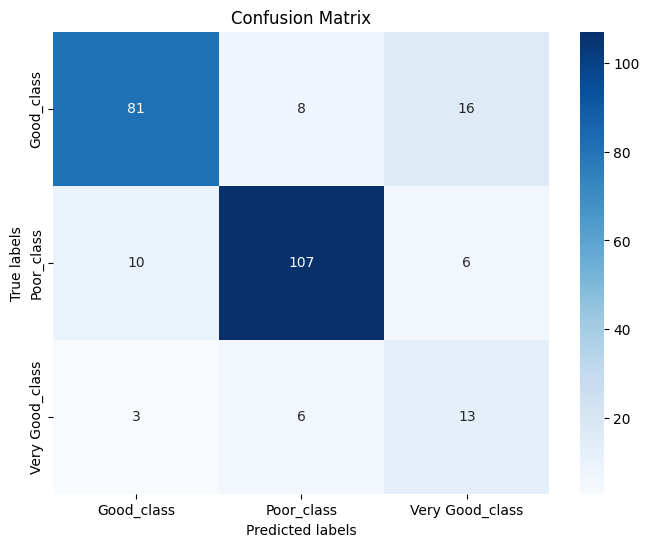

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

model = vgg_model
# Predict probabilities for test data
y_pred_prob = model.predict(test_images)
# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
# Convert one-hot encoded test labels to class labels
y_true = np.argmax(test_labels, axis=1)

# Calculate precision, recall, and F1-score
report = classification_report(y_true, y_pred, target_names=classes)
print("Classification Report:\n", report)

# Save classification report to a text file
with open('classification_report.txt', 'w') as f:
    f.write(report)

# Parse classification report into DataFrame
report_data = []
lines = report.split('\n')
for line in lines[2:-5]:
    row_data = line.split()
    if len(row_data) == 5:
        row_data = [row_data[0], *map(float, row_data[1:])]
        report_data.append(row_data)

# Convert classification report to DataFrame
metrics_df = pd.DataFrame(report_data, columns=['Class', 'Precision', 'Recall', 'F1-Score', 'Support'])

# Save classification report to Excel
metrics_df.to_excel(file_path + 'classification_report.xlsx', index=False)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig(file_path + 'confusion_matrix.png')  # Save confusion matrix image

# Convert confusion matrix to DataFrame
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

# Save confusion matrix to Excel
df_cm.to_excel(file_path + 'confusion_matrix.xlsx')
